# Heisenberg Model HOA + Trotter 

Uniform状態$\left|+\right>^N$におけるHeisenberg Modelハミルトニアンのエネルギー期待値を， HOA + Trotterで計算する．

In [1]:
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.state import inner_product
from qulacs.gate import *
import numpy as np

## パウリ回転行列とその他関数の定義

### 回転行列
J.Chem.Phys.137,224109 (2012)を参考に実装．
なお，同様のことは以下のコマンドでできる．(ことに後から気付いた．)
```python
circuit.add_parametric_multi_Pauli_rotation_gate(target:list, pauli_ids:list, angle:float)
```

PRX.Quantum.2,030318 (2021)の論文ではMølmer Gateを定義してから`exp_yy`,`exp_zz`を作成していた．


In [2]:
def exp_zz(theta,target,control):
    unitary = merge(CNOT(target,control),RZ(control,2*theta))
    unitary = merge(unitary,CNOT(target,control))
    return unitary

def exp_xx(theta,target,control):
    trans = merge(H(target),H(control))
    unitary = merge(trans,exp_zz(theta,target,control))
    unitary = merge(unitary,trans)
    return unitary

def exp_yy(theta,target,control):
    trans = merge(S(target),S(control))
    ZZ = merge(Z(target),Z(control))
    trans_conj = merge(ZZ,trans)
    unitary = merge(trans,exp_xx(theta,target,control))
    unitary = merge(unitary,trans_conj)
    return unitary

def T_Heisenberg(J,h,N,r,t):
    circuit = QuantumCircuit(N)
    theta_J = J/(2*r)*t
    theta_h = h/r*t
    for step in range(r):
        for i in range(N-1):
            circuit.add_gate(exp_xx(theta_J,i,i+1))
            circuit.add_gate(exp_yy(theta_J,i,i+1))
            circuit.add_gate(exp_zz(theta_J,i,i+1))
        for i in range(N):
            circuit.add_gate(RZ(i,theta_h*2))
        for i in range(N-1):
            circuit.add_gate(exp_zz(theta_J,i,i+1))
            circuit.add_gate(exp_yy(theta_J,i,i+1))
            circuit.add_gate(exp_xx(theta_J,i,i+1))
    return circuit

def Derive_q(S:int,s:float):
    """
    solve Simultaneous equations
    returns vector q as numpy.array
    """
    M = []
    D = [0]*S
    D[1] = 1
    for i in range(S):
        M.append([])
        for j in range(S):
            M[-1].append((-s+j)**(i))
    M = np.array(M)
    q = np.linalg.inv(M)@D
    return q

def UniformState(N):
    state = QuantumState(N)
    for i in range(N):
        H(i).update_quantum_state(state)
    return state

def Uniform_Expectation(circuit):
    bra = UniformState(N)
    ket = UniformState(N)
    circuit.update_quantum_state(ket)
    return inner_product(bra,ket)


## Derive expectation

Let the state be $\left|+\right>$. Then, the expectation will be
\begin{eqnarray}
    \left<+\left|^n -J\sum_{i=0}^{N-2}\hat s_{i} \cdot\hat s_{i+1} - h\sum_{i=0}^{N-1}\hat Z_{i} \right| + \right>^n = -J(N-1).
\end{eqnarray}

Below, $\left|+\right>$ is prepared by Hadamard Gate.

In [3]:
J,h,N,r=1,1,8,7

def total_uniform_Expectation(J,h,N,r,delta,s_max):
    s = (s_max-1)/2
    veq_q = Derive_q(S=s_max,s=s)
    Energy = 0
    for i in range(s_max):
        exp_hamil = T_Heisenberg(J=J,h=h,N=N,r=r,t=delta*(-s+i))
        Energy += (1j/delta) * veq_q[i] * Uniform_Expectation(circuit=exp_hamil)
    return np.real(Energy)

#total_uniform_Expectation(J=J,h=h,N=N,r=r,delta=delta,s_max=s_max)

Exact_uniform = -J*(N-1)

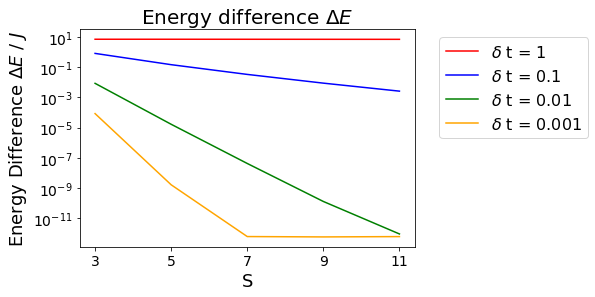

In [5]:
import matplotlib.pyplot as plt

list_S = [3,5,7,9,11]

### delta_t = 1
list_approx_value = []
for s_max in list_S:
    approx_value = total_uniform_Expectation(J=J,h=h,N=N,r=r,delta=1,s_max=s_max)
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-Exact_uniform)
plt.plot(x,y,color='red',label="$\delta$ t = 1")

### delta_t = 0.1
list_approx_value = []
for s_max in list_S:
    approx_value = total_uniform_Expectation(J=J,h=h,N=N,r=r,delta=0.1,s_max=s_max)
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-Exact_uniform)
plt.plot(x,y,color='blue',label="$\delta$ t = 0.1")

### delta_t = 0.01
list_approx_value = []
for s_max in list_S:
    approx_value = total_uniform_Expectation(J=J,h=h,N=N,r=r,delta=0.01,s_max=s_max)
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-Exact_uniform)
plt.plot(x,y,color='green',label="$\delta$ t = 0.01")

### delta_t = 0.001
list_approx_value = []
for s_max in list_S:
    approx_value = total_uniform_Expectation(J=J,h=h,N=N,r=r,delta=0.001,s_max=s_max)
    list_approx_value.append(np.real(approx_value))
x=np.array(list_S)
y=np.abs(np.array(list_approx_value)-Exact_uniform)
plt.plot(x,y,color='orange',label="$\delta$ t = 0.001")


plt.title("Energy difference $\Delta E$",fontsize=20)
plt.xlabel('S',fontsize=18)
plt.ylabel('Energy Difference $\Delta E ~ / ~ J$',fontsize=18)
ax = plt.gca()
ax.set_yscale('log')
plt.grid([])
plt.xticks(list_S,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
plt.show()